<a href="https://colab.research.google.com/github/Shyamsundarkanaka/Rossmann-Sales-Prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

#Import Libries for graph
import matplotlib.pyplot as plt
import seaborn as sns

#Time Series Analysis
from statsmodels.tsa.seasonal import  seasonal_decompose

#Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Import the Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

#Cross Validation and Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

#import the metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Loading the data set and Overview

In [3]:
#Loading the data set
path = '/content/drive/MyDrive/Colab Notebooks/Data science/Capstone Projects/Retail Sales Prediction - Shyam Sundar K/Data'
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data science/Capstone Projects/Retail Sales Prediction - Shyam Sundar K/Data/Rossmann Stores Data.csv')
df_meta = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data science/Capstone Projects/Retail Sales Prediction - Shyam Sundar K/Data/store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print(df.shape)
print(df_meta.shape)

(1017209, 9)
(1115, 10)


In [5]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_meta

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [9]:
#checking the null values for main dataset
df.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [10]:
#checking the null vaues for meta data
temp = df_meta.isna().sum()
temp

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [11]:
pd.DataFrame(temp, columns=['No of Null Values'])

,No of Null Values
Store,0
StoreType,0
Assortment,0
CompetitionDistance,3
CompetitionOpenSinceMonth,354
CompetitionOpenSinceYear,354
Promo2,0
Promo2SinceWeek,544
Promo2SinceYear,544
PromoInterval,544


In [12]:
# sorting the data
df = df.sort_values('Date')

In [13]:
df.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,2015-03-04,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


In [14]:
df_meta.Promo2SinceYear.value_counts()

2011.0    128
2013.0    120
2014.0     95
2012.0     81
2009.0     73
2010.0     64
2015.0     10
Name: Promo2SinceYear, dtype: int64

In [15]:
df_meta.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [16]:
df_meta.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.00000,1115,1115,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.00000,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.00000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN
25%,279.50000,NaN,NaN,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN
50%,558.00000,NaN,NaN,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,NaN
75%,836.50000,NaN,NaN,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000,NaN


In [17]:
df_meta[df_meta.CompetitionOpenSinceMonth.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## We can see that there are 2 data sets, main data of over a million rows which has data or 1115 stores and there is one more data set that gives information for each of these store

##Data Cleaning

In [18]:
#taking a backup for meta data before cleaning
df_meta_backup = df_meta.copy()

In [19]:
df_meta.CompetitionOpenSinceYear.mean()

2008.6688567674114

In [20]:
# Checking the percentage of shops open before 2013
df_meta[df_meta.CompetitionOpenSinceYear >2013].shape[0]/df_meta[df_meta.CompetitionOpenSinceYear <2013].shape[0]

0.18947368421052632

In [21]:
df_meta[df_meta.CompetitionOpenSinceYear >2014].shape

(38, 10)

In [22]:
#Droping the rows 'CompetitionOpenSinceYear','CompetitionOpenSinceMonth'
df_meta.drop(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'],axis=1,inplace=True)

### We can see there are lot of null values in competetion open since Year, and for available data we can more than 80% of the competitors open before 2013, and we are doing analysis for sales after 2013, we will drop the columns CompetitionOpenSinceYear and CompetitionOpenSinceMonth

In [23]:

df_meta[df_meta.CompetitionDistance.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [24]:
# Fillng the null values
df_meta.CompetitionDistance.fillna(value = df_meta.CompetitionDistance.mean(), inplace = True)

In [25]:
df_meta.CompetitionDistance.isnull().sum()

0

### Filling the 3 missing values in competetion distance by mean value of the column.

In [26]:
df_meta[df_meta.Promo2==0].isna().sum()

Store                    0
StoreType                0
Assortment               0
CompetitionDistance      0
Promo2                   0
Promo2SinceWeek        544
Promo2SinceYear        544
PromoInterval          544
dtype: int64

In [27]:
df_meta.Promo2SinceYear.value_counts()

2011.0    128
2013.0    120
2014.0     95
2012.0     81
2009.0     73
2010.0     64
2015.0     10
Name: Promo2SinceYear, dtype: int64

In [28]:
type(df.Date.max())

str

In [29]:
df.Date = pd.to_datetime(df.Date)
print(df.Date.max())
print(df.Date.max().year)
print(df.Date.max().week)

2015-07-31 00:00:00
2015
31


In [30]:
df_meta.Promo2SinceYear.fillna(value = (df.Date.max().year),inplace=True)
df_meta.Promo2SinceWeek.fillna(value = (df.Date.max().week),inplace=True)
df_meta.isnull().sum()

Store                    0
StoreType                0
Assortment               0
CompetitionDistance      0
Promo2                   0
Promo2SinceWeek          0
Promo2SinceYear          0
PromoInterval          544
dtype: int64

### We are filling null of the promo2 date after the latest day of the available data. It is done as it makes it easy for us to check if the promotion was active while merging the datasets.

In [31]:
df_meta.PromoInterval.fillna(value = 'None',inplace=True)

### We are filling null of the promoInterval with None which will be used for one hot encoding once the datasets are merged.

In [32]:
import datetime
from dateutil.relativedelta import relativedelta

def get_date(year,week):
  year = int(year)
  week = int(week)
  date = datetime.date(year, 1, 1) + relativedelta(weeks=+week)
  return(date)

In [33]:
# Creating a date column using 'Promo2SinceWeek','Promo2SinceYear' columns
df_meta['promo2_start_date'] = df_meta.apply(lambda x: get_date(x.Promo2SinceYear,x.Promo2SinceWeek),axis=1)


In [34]:
# We can drop the 3 columns has we have creted a new columns of promo2_start_date
df_meta.drop(['Promo2','Promo2SinceWeek','Promo2SinceYear'],axis=1,inplace=True)

### 'Promo2','Promo2SinceWeek','Promo2SinceYear' are merged as one promo2_start_date. Now the data set is ready to be merged.

In [35]:
df_meta

,Store,StoreType,Assortment,CompetitionDistance,PromoInterval,promo2_start_date
0,1,c,a,1270.0,None,2015-08-06
1,2,a,a,570.0,"Jan,Apr,Jul,Oct",2010-04-02
2,3,a,a,14130.0,"Jan,Apr,Jul,Oct",2011-04-09
3,4,c,c,620.0,None,2015-08-06
4,5,a,a,29910.0,None,2015-08-06
...,...,...,...,...,...,...
1110,1111,a,a,1900.0,"Jan,Apr,Jul,Oct",2013-08-06
1111,1112,c,c,1880.0,None,2015-08-06
1112,1113,a,c,9260.0,None,2015-08-06
1113,1114,a,c,870.0,None,2015-08-06


# Merging Data sets

In [36]:
#taking a backup of main dataset
df_backup = df.copy()

In [37]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017208,1115,2,2013-01-01,0,0,0,0,a,1
1016473,379,2,2013-01-01,0,0,0,0,a,1
1016472,378,2,2013-01-01,0,0,0,0,a,1
1016471,377,2,2013-01-01,0,0,0,0,a,1
1016470,376,2,2013-01-01,0,0,0,0,a,1


In [38]:
#merging the meta data with main dataset
df = pd.merge(df, df_meta, on='Store', how='left')

In [39]:
df.shape

(1017209, 14)

In [40]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,promo2_start_date
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,None,2015-08-06
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,None,2015-08-06
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,"Feb,May,Aug,Nov",2010-05-07
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,None,2015-08-06


In [41]:
#converting the datatype to date wherever necessary
df.Date = pd.to_datetime(df.Date)
df.promo2_start_date = pd.to_datetime(df.promo2_start_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   StoreType            1017209 non-null  object        
 10  Assortment           1017209 non-null  object        
 11  CompetitionDistance  1017209 non-null  float64       
 12  PromoInterval        1017209 non-null  object        
 1

In [42]:
#Create a new column for promo active or not
df['Promo2_active'] = np.where(df['Date'] >= df['promo2_start_date'], 1 , 0)



In [43]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,promo2_start_date,Promo2_active
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03,1
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,None,2015-08-06,0
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,None,2015-08-06,0
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,"Feb,May,Aug,Nov",2010-05-07,1
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,None,2015-08-06,0


In [44]:
#Droping the promo2 start date column
df.drop(columns = ['promo2_start_date'], axis=1,inplace= True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   StoreType            1017209 non-null  object        
 10  Assortment           1017209 non-null  object        
 11  CompetitionDistance  1017209 non-null  float64       
 12  PromoInterval        1017209 non-null  object        
 1

In [46]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'PromoInterval', 'Promo2_active'],
      dtype='object')

# EDA

In [47]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,Promo2_active
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,None,0
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,None,0
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,"Feb,May,Aug,Nov",1
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,None,0


2013
2014
2015


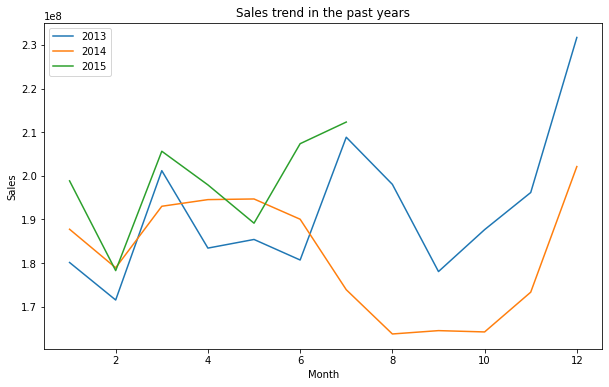

In [48]:
# Sales vs Time graph in terms of years
plt.figure(figsize=(10,6))
for y in set(df.Date.dt.year):
  print(y)
  df_temp = pd.DataFrame(df[df.Date.dt.year==y].groupby(df.Date.dt.month)['Sales'].sum())
  plt.plot(df_temp,label=y)
  plt.title('Sales trend in the past years')
  plt.legend()
  plt.xlabel("Month")
  plt.ylabel("Sales")

2013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


2014


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


2015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


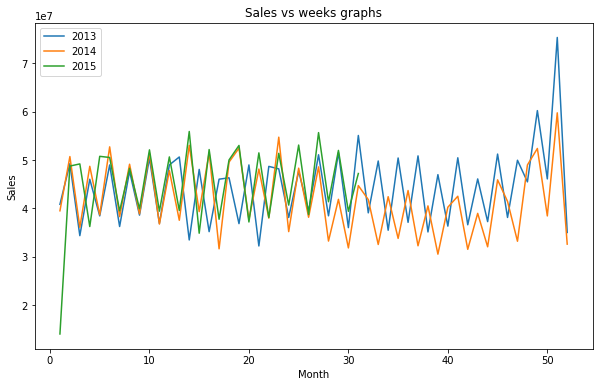

In [49]:
# Sales vs weeks graphs
plt.figure(figsize=(10,6))
for y in set(df.Date.dt.year):
  print(y)
  df_temp = pd.DataFrame(df[df.Date.dt.year==y].groupby(df.Date.dt.week)['Sales'].sum())
  plt.plot(df_temp,label=y)
  plt.legend()
  plt.xlabel("Month")
  plt.ylabel("Sales")
  plt.title('Sales vs weeks graphs')
plt.show()

,Sales
Date,
2013,406974
2014,373855
2015,236380


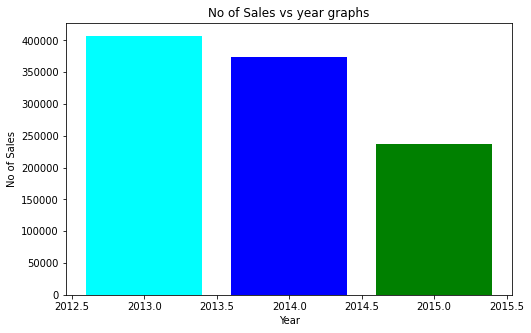

In [50]:
# Checking over all sales for each year
plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.Date.dt.year)['Sales'].count())
plt.xlabel("Year")
plt.ylabel("No of Sales")
plt.title('No of Sales vs year graphs')

plt.bar(df_temp.index, df_temp.Sales, color = ['cyan', 'blue', 'green'])
df_temp

,Sales
Date,
2013,2302876084
2014,2180804896
2015,1389499643


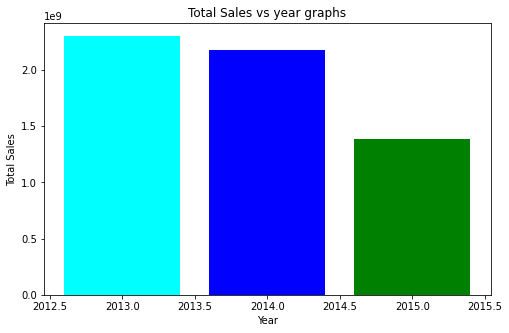

In [51]:
# Checking over all sales for each year
plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.Date.dt.year)['Sales'].sum())
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.title('Total Sales vs year graphs')

plt.bar(df_temp.index, df_temp.Sales, color = ['cyan', 'blue', 'green'])
df_temp

<BarContainer object of 7 artists>

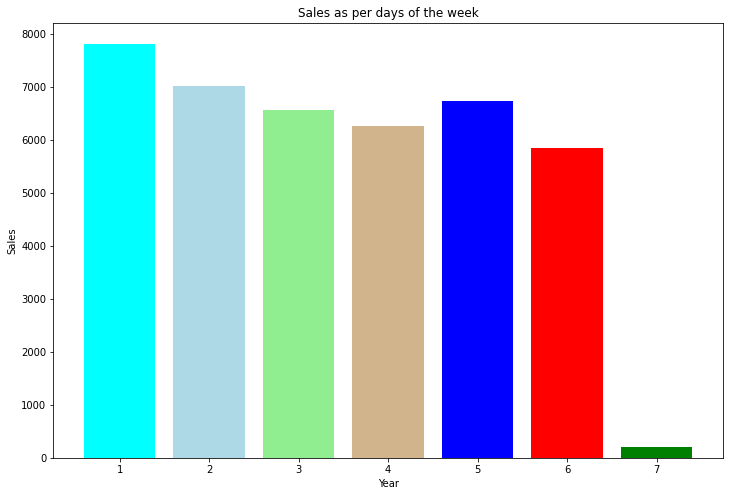

In [52]:
# Sales as per days of the week
plt.figure(figsize=(12,8))
df_temp = pd.DataFrame(df.groupby(df.DayOfWeek)['Sales'].mean())
days = {'1':'m','2':'t','3':'w','4':'t','5':'f','6':'s','7':'s'}

plt.xlabel("Year")
plt.ylabel("Sales")
plt.title('Sales as per days of the week')

plt.bar(df_temp.index, df_temp.Sales, color = ['cyan', 'lightblue', 'lightgreen', 'tan','blue','red','green'])

<BarContainer object of 7 artists>

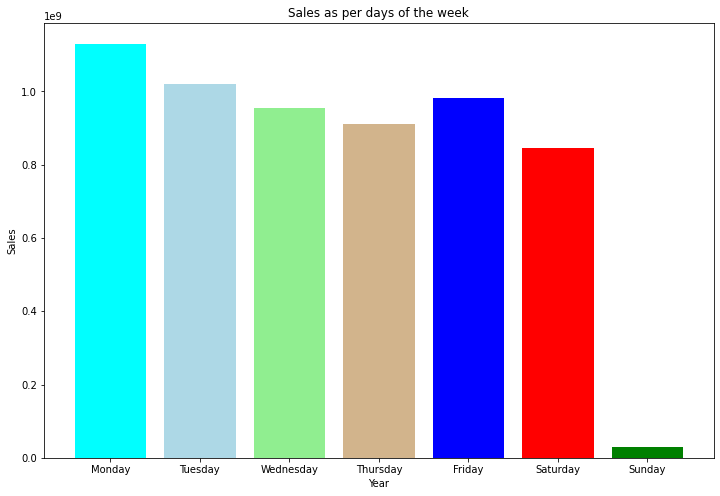

In [53]:
df
plt.figure(figsize=(12,8))
df_temp = pd.DataFrame(df.groupby(df.Date.dt.day_name())['Sales'].sum())
df_temp = df_temp.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title('Sales as per days of the week')
plt.bar(df_temp.index, df_temp.Sales, color = ['cyan', 'lightblue', 'lightgreen', 'tan','blue','red','green'])


best fit line:
y = 1077.74 + 7.42x


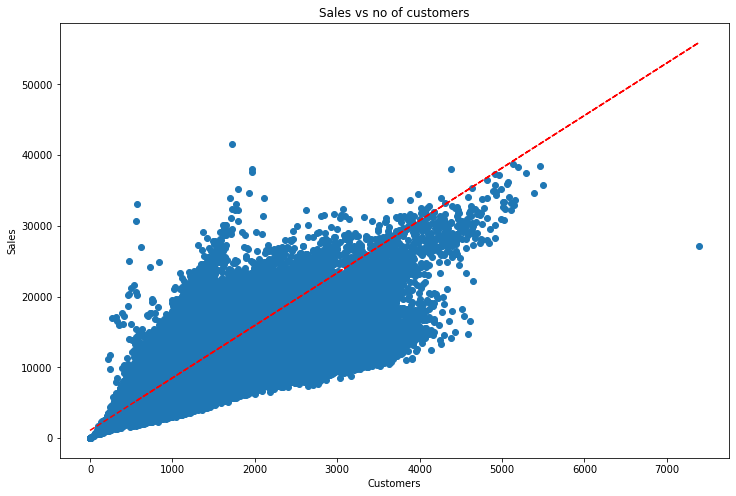

In [54]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

plt.figure(figsize=(12,8))
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title('Sales vs no of customers')
a, b = best_fit(df.Customers, df.Sales)
yfit = [a + b * i for i in df.Customers]
plt.scatter(df.Customers,df.Sales)
plt.plot(df.Customers, yfit, color = 'red',linestyle = 'dashed')
plt.show()

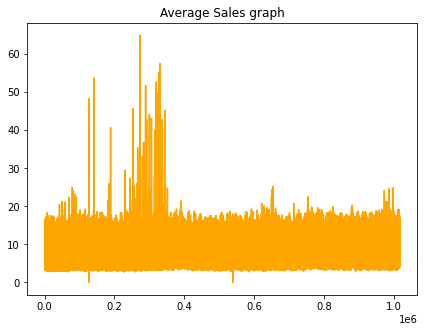

In [55]:
plt.figure(figsize=(7,5))
plt.plot((df.Sales/df.Customers),color='orange')
'''
plt.ylabel('Average Sales')
plt.xlabel('Customers')
plt.xticks()
'''
plt.title('Average Sales graph')
plt.show()

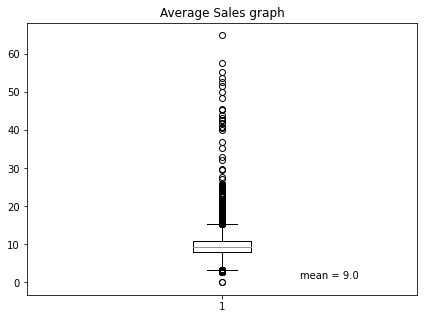

In [56]:
plt.figure(figsize=(7,5))
plt.boxplot((df[df.Customers != 0 ].Sales/df[df.Customers != 0].Customers))
'''
plt.ylabel('Average Sales')
plt.xlabel('Customers')
plt.xticks()
'''
plt.text(1.2,1,'mean = ' + str(round((df[df.Customers != 0 ].Sales/df[df.Customers != 0].Customers).mean(),0)))
plt.title('Average Sales graph')
plt.show()

1    844392
0    172817
Name: Open, dtype: int64
           Sales
Open            
0              0
1     5873180623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


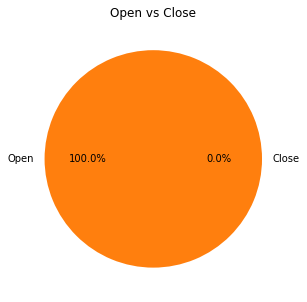

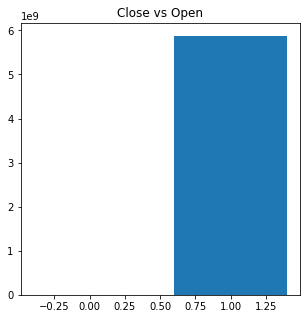

In [57]:

df_temp = pd.DataFrame(df.groupby(df.Open)['Sales'].sum())

print(df.Open.value_counts())
print(df_temp)

plt.figure(figsize=(5,5))
plt.pie(df_temp,autopct='%1.1f%%',labels=['Close', 'Open'])
plt.title('Open vs Close')
plt.show()

plt.figure(figsize=(5,5))
plt.bar(df_temp.index, df_temp.Sales)
plt.title('Close vs Open')
plt.show()

#plt.pie(  )

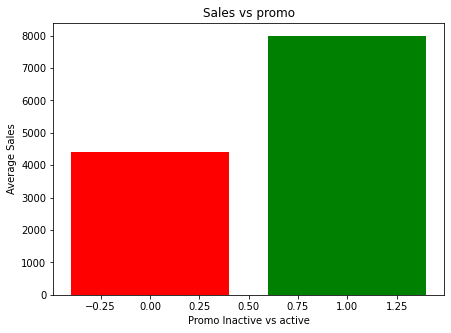

In [58]:
# Difference in sales if the promo was active
plt.figure(figsize=(7,5))
df_temp = pd.DataFrame(df.groupby(df.Promo)['Sales'].mean())
plt.bar(df_temp.index,df_temp.Sales, color =['red','green'])
plt.ylabel('Average Sales')
plt.xlabel('Promo Inactive vs active')
plt.xticks()
plt.title('Sales vs promo')
plt.show()

In [59]:
df.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [60]:
df.StateHoliday = df.StateHoliday.astype('string')


<BarContainer object of 4 artists>

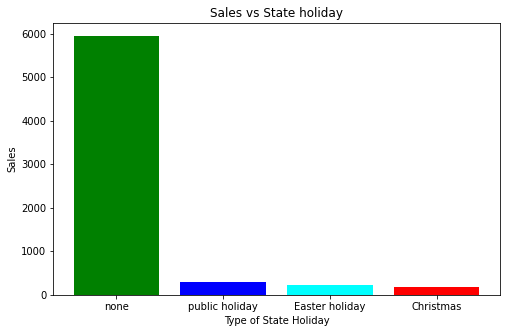

In [61]:
plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.StateHoliday)['Sales'].mean())
df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel("Type of State Holiday")
plt.ylabel("Sales")
plt.title('Sales vs State holiday')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','cyan','red'])

In [62]:
df.SchoolHoliday.value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

No handles with labels found to put in legend.


<BarContainer object of 2 artists>

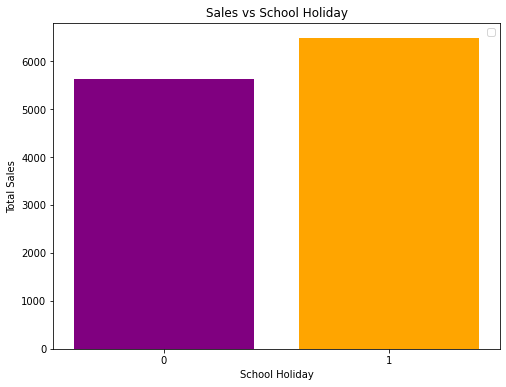

In [63]:
plt.figure(figsize=(8,6))
df_temp = pd.DataFrame(df.groupby(df.SchoolHoliday)['Sales'].mean())
df_temp.index = df_temp.index.astype('string')
#df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel('School Holiday')
plt.ylabel('Total Sales')
plt.title('Sales vs School Holiday')
plt.legend()
plt.bar(df_temp.index, df_temp.Sales, color = ['purple','orange'])#,'cyan','red'])

   StoreType
a     551627
d     312912
c     136840
b      15830


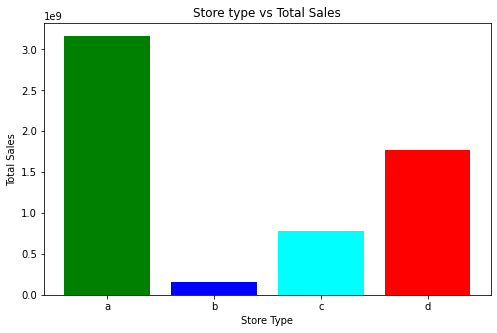

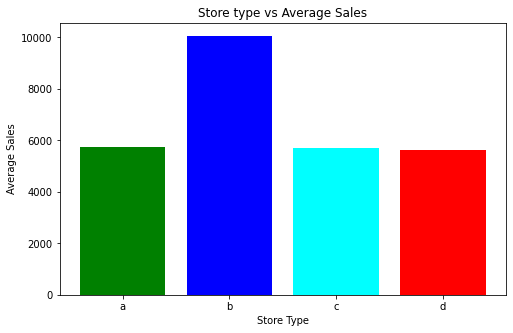

In [64]:
plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.StoreType)['Sales'].sum())
df_temp.index = df_temp.index.astype('string')
#df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.title('Store type vs Total Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','cyan','red'])

plt.figure(figsize=(8,5))

df_temp = pd.DataFrame(df.groupby(df.StoreType)['Sales'].mean())
df_temp.index = df_temp.index.astype('string')
#df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Store type vs Average Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','cyan','red'])
print(pd.DataFrame(df.StoreType.value_counts()))

   Assortment
a      537445
c      471470
b        8294


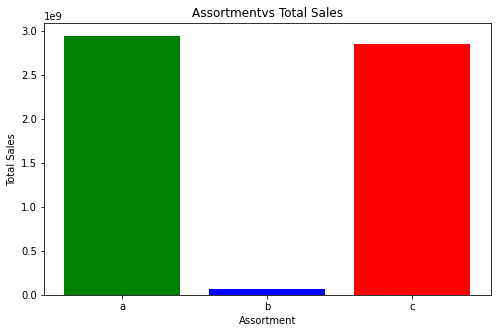

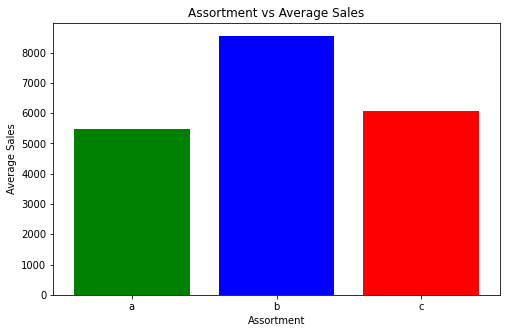

In [65]:
plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.Assortment)['Sales'].sum())
df_temp.index = df_temp.index.astype('string')
#df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel('Assortment')
plt.ylabel('Total Sales')
plt.title('Assortmentvs Total Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','red'])

plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.Assortment)['Sales'].mean())
df_temp.index = df_temp.index.astype('string')
#df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel('Assortment')
plt.ylabel('Average Sales')
plt.title('Assortment vs Average Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','red'])
print(pd.DataFrame(df.Assortment.value_counts()))

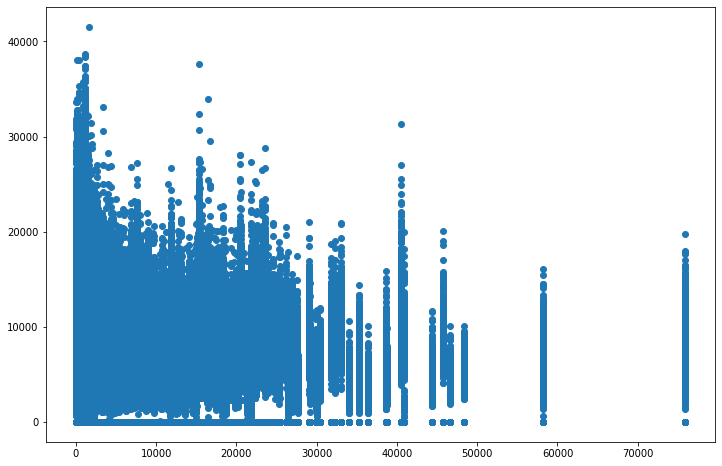

In [66]:
plt.figure(figsize=(12,8))
plt.scatter(df.CompetitionDistance,df.Sales)

None                508031
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64


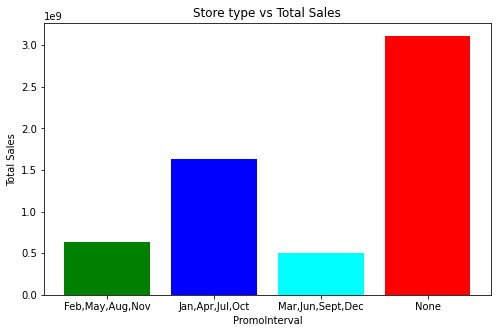

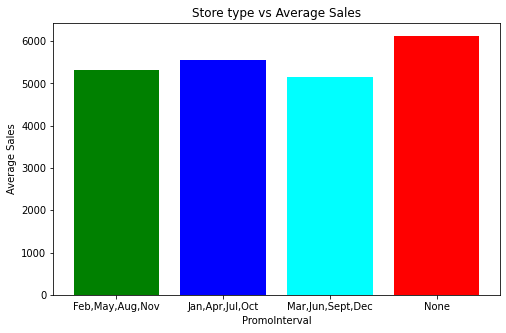

In [67]:
plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.PromoInterval)['Sales'].sum())


plt.xlabel('PromoInterval')
plt.ylabel('Total Sales')
plt.title('Store type vs Total Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','cyan','red'])

plt.figure(figsize=(8,5))

df_temp = pd.DataFrame(df.groupby(df.PromoInterval)['Sales'].mean())

plt.xlabel('PromoInterval')
plt.ylabel('Average Sales')
plt.title('Store type vs Average Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','cyan','red'])
print(df.PromoInterval.value_counts())

## Insights
> There is fall in sales in the month of Feb and then again there is decreasing trend in the months August, September and then the sales touches the peak in December. 

> The average sales varies between 5800 to 7800 from monday to saturday and the sales are very low on sundays as most of the shops are closed on sundays. 

> Average sale per customer mostly lies between 4 and 20, however we can see some outlier vales that goes upto 70 and the mean value is 9.

> There is a significant increase in sales when the promo is active. 

> Sales reduces drastically during the State  as most the shops remains closed. 

> There is a increase in average sales during the school holidays.

> Store type A,C,D have approximately same average sales and Store type B has much higher average Sales, but the number of stores of Type B is very less. 

> Assortment type A and C have approximately same average sales and Assortment type B has higher average Sales, but the number of stores of Assortment Type B is very less. 

> Promo2 Interval has no effect on sales, infact the shops with no promostions also performs well


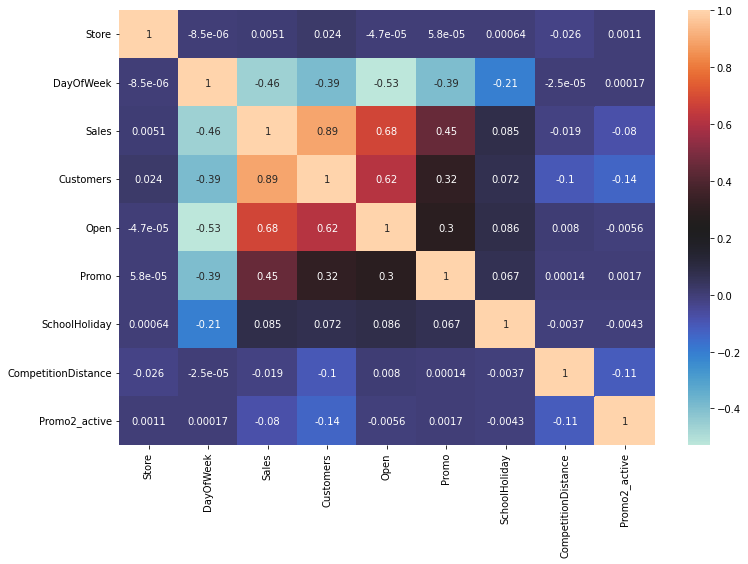

In [68]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),cmap='icefire', annot=True)
plt.show()

# Time Series Analysis

In [69]:
ts = pd.DataFrame(df[['Date','Sales']])
ts

,Date,Sales
0,2013-01-01,0
1,2013-01-01,0
2,2013-01-01,0
3,2013-01-01,0
4,2013-01-01,0
...,...,...
1017204,2015-07-31,9082
1017205,2015-07-31,10708
1017206,2015-07-31,7481
1017207,2015-07-31,10460


In [70]:
ts = df.groupby(['Date'])['Sales'].sum()

ts

Date
2013-01-01       97235
2013-01-02     6949829
2013-01-03     6347820
2013-01-04     6638954
2013-01-05     5951593
                ...   
2015-07-27    10707292
2015-07-28     9115073
2015-07-29     8499962
2015-07-30     8798854
2015-07-31    10109742
Name: Sales, Length: 942, dtype: int64

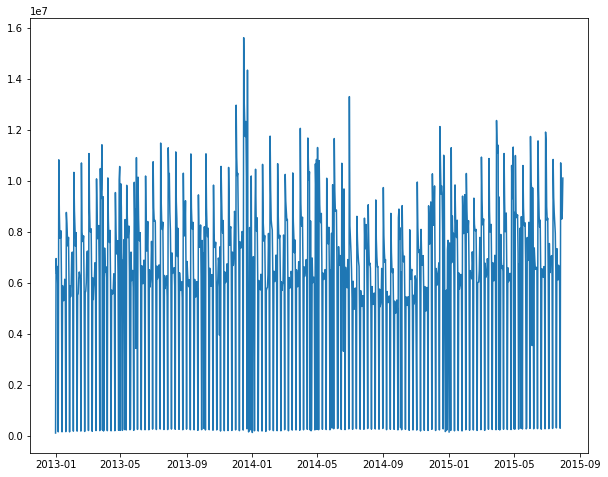

In [71]:
plt.figure(figsize=(10,8))
plt.plot(ts.index, ts)
plt.show()

In [72]:
result = seasonal_decompose(ts,model='additive',freq=30)

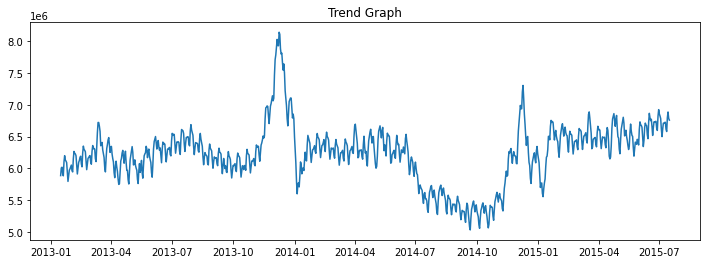

In [73]:

plt.figure(figsize=(12,4))
plt.plot(result.trend)
plt.title("Trend Graph")
plt.show()

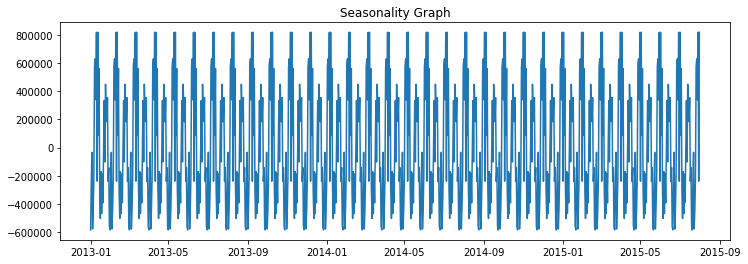

In [74]:

plt.figure(figsize=(12,4))
plt.plot(result.seasonal)
plt.title("Seasonality Graph")

plt.show()

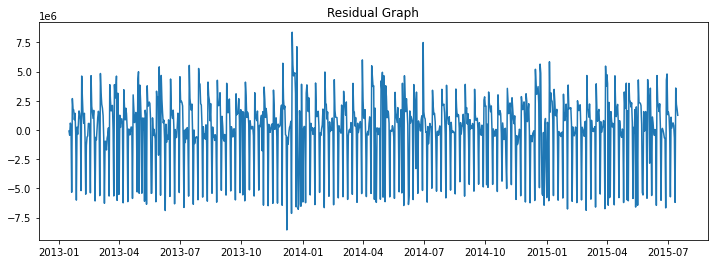

In [75]:

plt.figure(figsize=(12,4))
plt.plot(result.resid)
plt.title("Residual Graph")
plt.show()

In [76]:
df[df.Sales == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,Promo2_active
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,None,0
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,None,0
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,"Feb,May,Aug,Nov",1
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014546,876,3,2015-07-29,0,0,0,1,0,1,a,a,21790.0,"Feb,May,Aug,Nov",1
1015076,292,4,2015-07-30,0,0,0,1,0,1,a,a,1100.0,None,0
1015659,876,4,2015-07-30,0,0,0,1,0,1,a,a,21790.0,"Feb,May,Aug,Nov",1
1016191,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,None,0


In [77]:
ts = pd.DataFrame(df[['Date','Sales']])
ts

,Date,Sales
0,2013-01-01,0
1,2013-01-01,0
2,2013-01-01,0
3,2013-01-01,0
4,2013-01-01,0
...,...,...
1017204,2015-07-31,9082
1017205,2015-07-31,10708
1017206,2015-07-31,7481
1017207,2015-07-31,10460


In [78]:
ts = df.groupby(['Date'])['Sales'].sum()

ts

Date
2013-01-01       97235
2013-01-02     6949829
2013-01-03     6347820
2013-01-04     6638954
2013-01-05     5951593
                ...   
2015-07-27    10707292
2015-07-28     9115073
2015-07-29     8499962
2015-07-30     8798854
2015-07-31    10109742
Name: Sales, Length: 942, dtype: int64

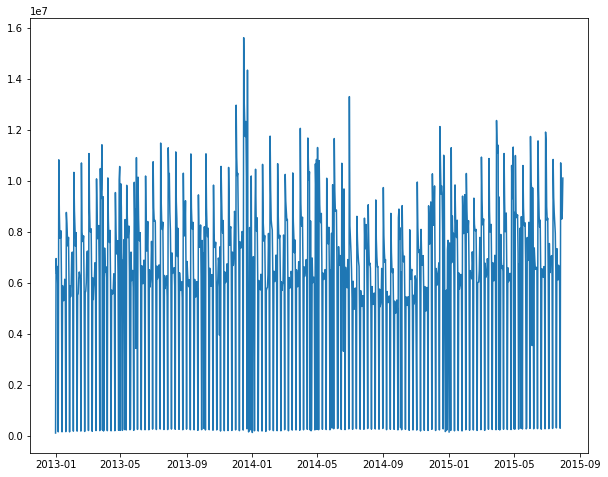

In [79]:
plt.figure(figsize=(10,8))
plt.plot(ts.index, ts)
plt.show()

In [80]:
result = seasonal_decompose(ts,model='additive',freq=12)

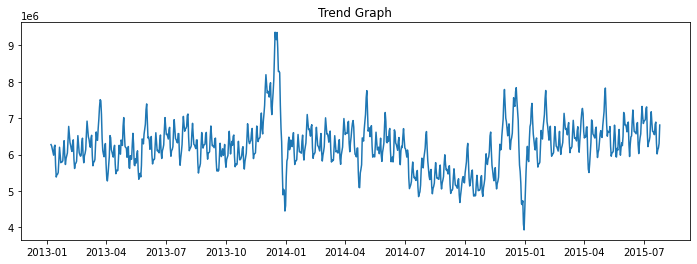

In [81]:

plt.figure(figsize=(12,4))
plt.plot(result.trend)
plt.title("Trend Graph")
plt.show()

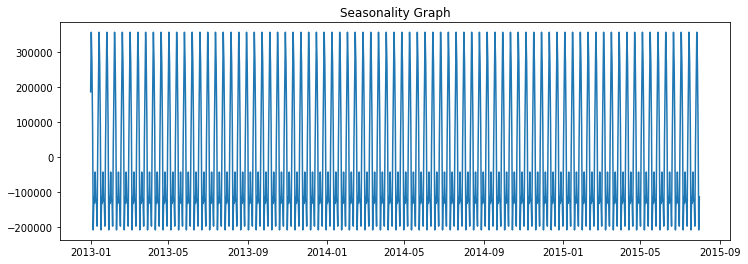

In [82]:

plt.figure(figsize=(12,4))
plt.plot(result.seasonal)
plt.title("Seasonality Graph")

plt.show()

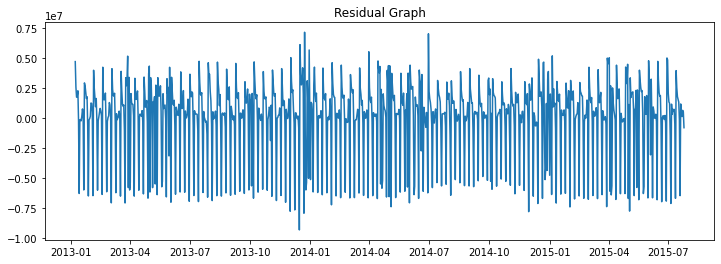

In [83]:

plt.figure(figsize=(12,4))
plt.plot(result.resid)
plt.title("Residual Graph")
plt.show()

In [84]:
df[df.Sales == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,Promo2_active
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,None,0
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,None,0
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,"Feb,May,Aug,Nov",1
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014546,876,3,2015-07-29,0,0,0,1,0,1,a,a,21790.0,"Feb,May,Aug,Nov",1
1015076,292,4,2015-07-30,0,0,0,1,0,1,a,a,1100.0,None,0
1015659,876,4,2015-07-30,0,0,0,1,0,1,a,a,21790.0,"Feb,May,Aug,Nov",1
1016191,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,None,0


In [85]:
ts = pd.DataFrame(df[['Date','Sales']])
ts

,Date,Sales
0,2013-01-01,0
1,2013-01-01,0
2,2013-01-01,0
3,2013-01-01,0
4,2013-01-01,0
...,...,...
1017204,2015-07-31,9082
1017205,2015-07-31,10708
1017206,2015-07-31,7481
1017207,2015-07-31,10460


In [86]:
ts = df.groupby(['Date'])['Sales'].sum()

ts

Date
2013-01-01       97235
2013-01-02     6949829
2013-01-03     6347820
2013-01-04     6638954
2013-01-05     5951593
                ...   
2015-07-27    10707292
2015-07-28     9115073
2015-07-29     8499962
2015-07-30     8798854
2015-07-31    10109742
Name: Sales, Length: 942, dtype: int64

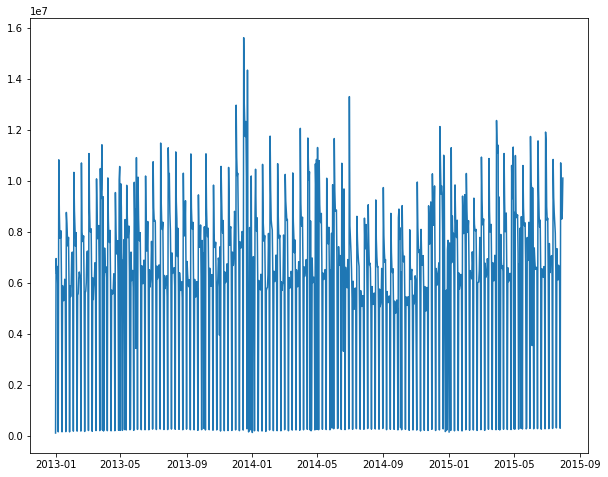

In [87]:
plt.figure(figsize=(10,8))
plt.plot(ts.index, ts)
plt.show()

In [88]:
result = seasonal_decompose(ts,model='additive',freq=30)

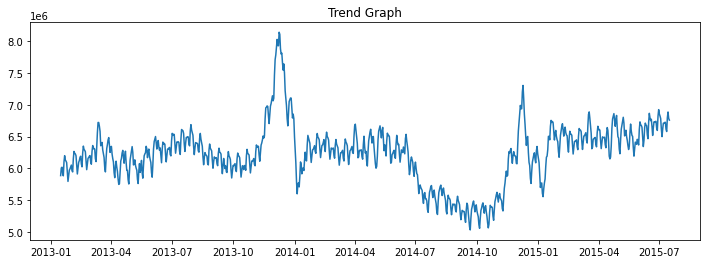

In [89]:

plt.figure(figsize=(12,4))
plt.plot(result.trend)
plt.title("Trend Graph")
plt.show()

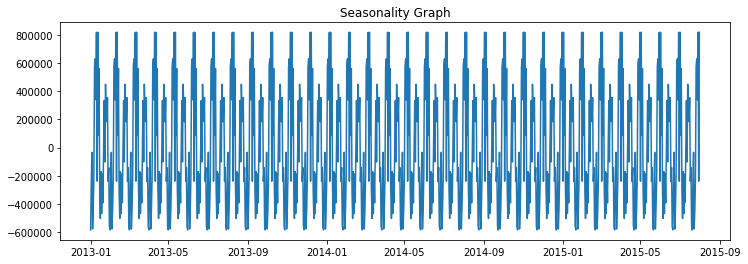

In [90]:

plt.figure(figsize=(12,4))
plt.plot(result.seasonal)
plt.title("Seasonality Graph")

plt.show()

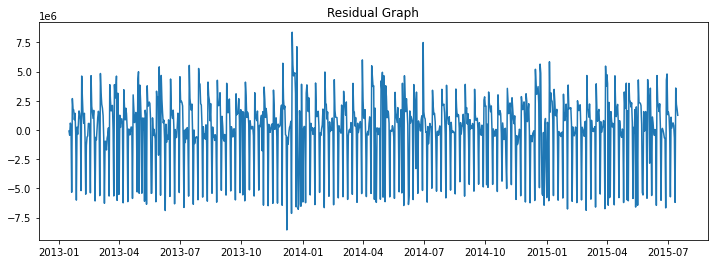

In [91]:

plt.figure(figsize=(12,4))
plt.plot(result.resid)
plt.title("Residual Graph")
plt.show()

In [92]:
df[df.Sales == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,Promo2_active
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,None,0
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,None,0
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,"Feb,May,Aug,Nov",1
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014546,876,3,2015-07-29,0,0,0,1,0,1,a,a,21790.0,"Feb,May,Aug,Nov",1
1015076,292,4,2015-07-30,0,0,0,1,0,1,a,a,1100.0,None,0
1015659,876,4,2015-07-30,0,0,0,1,0,1,a,a,21790.0,"Feb,May,Aug,Nov",1
1016191,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,None,0


# Feature Engineering

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


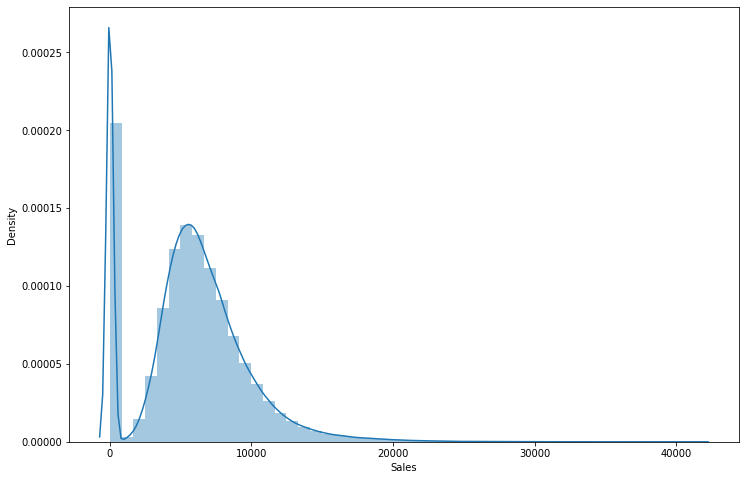

In [93]:
dependent_feature = df.Sales
plt.figure(figsize=(12,8))
sns.distplot(dependent_feature)
plt.show()

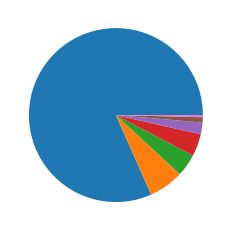

In [94]:
plt.pie(list(df[df.Sales == 0].DayOfWeek.value_counts()))
plt.show()

In [95]:
df[df.Open==0][df.Sales!=0].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(0, 14)

## We notice that Sales is 0 for all rows where Open is 0, so we can simply predict the sales to be 0 if the open column is 0 and drop the those rows for our modeling. 

In [96]:
df = df[df.Open!=0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


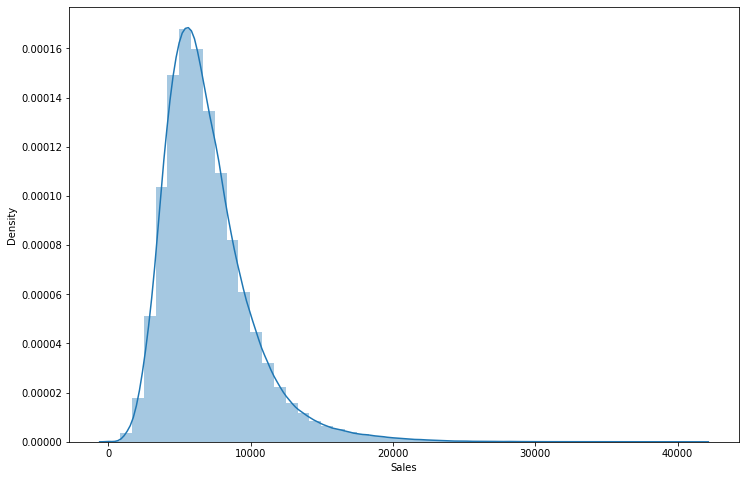

In [97]:
dependent_feature = df.Sales
plt.figure(figsize=(12,8))
sns.distplot(dependent_feature)
plt.show()

In [98]:
#independent_features = ['Store','DayOfWeek','Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType','PromoInterval' ]

In [99]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 27 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                844392 non-null  int64         
 1   DayOfWeek            844392 non-null  int64         
 2   Date                 844392 non-null  datetime64[ns]
 3   Sales                844392 non-null  int64         
 4   Customers            844392 non-null  int64         
 5   Open                 844392 non-null  int64         
 6   Promo                844392 non-null  int64         
 7   StateHoliday         844392 non-null  string        
 8   SchoolHoliday        844392 non-null  int64         
 9   StoreType            844392 non-null  object        
 10  Assortment           844392 non-null  object        
 11  CompetitionDistance  844392 non-null  float64       
 12  PromoInterval        844392 non-null  object        
 13  Promo2_activ

In [100]:
df.SchoolHoliday.value_counts()
df.Assortment.value_counts()

a    444909
c    391271
b      8212
Name: Assortment, dtype: int64

In [101]:
# Extracting columns using date

df["month"] = df['Date'].dt.month                                # extract month name from Date column
df["day"] = df['Date'].dt.day                                    # extract month name from Date column
df["year"] = df['Date'].map(lambda x: x.year).astype("string")   # extract year from Date column and convert it in object type
df = df.drop(['Date'],axis=1)



In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 27 to 1017208
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844392 non-null  int64  
 1   DayOfWeek            844392 non-null  int64  
 2   Sales                844392 non-null  int64  
 3   Customers            844392 non-null  int64  
 4   Open                 844392 non-null  int64  
 5   Promo                844392 non-null  int64  
 6   StateHoliday         844392 non-null  string 
 7   SchoolHoliday        844392 non-null  int64  
 8   StoreType            844392 non-null  object 
 9   Assortment           844392 non-null  object 
 10  CompetitionDistance  844392 non-null  float64
 11  PromoInterval        844392 non-null  object 
 12  Promo2_active        844392 non-null  int64  
 13  month                844392 non-null  int64  
 14  day                  844392 non-null  int64  
 15  year           

In [103]:
df.year.value_counts()
df.Assortment.value_counts()

a    444909
c    391271
b      8212
Name: Assortment, dtype: int64

In [104]:
# Label Ecoding
encoders_nums = {"year":{"2013":1,"2014":2,"2015":3}, "Assortment":{"a":1,"b":2,"c":3} }
df = df.replace(encoders_nums)

In [105]:
df.Assortment.value_counts()

1    444909
3    391271
2      8212
Name: Assortment, dtype: int64

In [106]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,Promo2_active,month,day,year
27,353,2,3139,820,1,0,a,1,b,2,900.0,"Feb,May,Aug,Nov",0,1,1,1
115,335,2,2401,482,1,0,a,1,b,1,90.0,"Jan,Apr,Jul,Oct",0,1,1,1
147,512,2,2646,625,1,0,a,1,b,2,590.0,"Mar,Jun,Sept,Dec",0,1,1,1
162,494,2,3113,527,1,0,a,1,b,1,1260.0,None,0,1,1,1
199,530,2,2907,532,1,0,a,1,a,3,18160.0,None,0,1,1,1


In [107]:
# One hot encoding
print(df.StateHoliday.value_counts())
print(df.StoreType.value_counts())
print(df.PromoInterval.value_counts())

0    843482
a       694
b       145
c        71
Name: StateHoliday, dtype: Int64
a    457077
d    258774
c    112978
b     15563
Name: StoreType, dtype: int64
None                423307
Jan,Apr,Jul,Oct     242411
Feb,May,Aug,Nov      98005
Mar,Jun,Sept,Dec     80669
Name: PromoInterval, dtype: int64


In [108]:
# One hot encoding
df = pd.get_dummies(df, columns= ["StateHoliday", "StoreType","PromoInterval"])


In [109]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Assortment,CompetitionDistance,Promo2_active,month,day,year,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_None
27,353,2,3139,820,1,0,1,2,900.0,0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0
115,335,2,2401,482,1,0,1,1,90.0,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,0
147,512,2,2646,625,1,0,1,2,590.0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0
162,494,2,3113,527,1,0,1,1,1260.0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,1
199,530,2,2907,532,1,0,1,3,18160.0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1


In [110]:
df.drop(columns= ['StateHoliday_0','StoreType_b', 'PromoInterval_None'],inplace = True)

In [111]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Assortment,CompetitionDistance,Promo2_active,month,day,year,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_c,StoreType_d,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
27,353,2,3139,820,1,0,1,2,900.0,0,1,1,1,1,0,0,0,0,0,1,0,0
115,335,2,2401,482,1,0,1,1,90.0,0,1,1,1,1,0,0,0,0,0,0,1,0
147,512,2,2646,625,1,0,1,2,590.0,0,1,1,1,1,0,0,0,0,0,0,0,1
162,494,2,3113,527,1,0,1,1,1260.0,0,1,1,1,1,0,0,0,0,0,0,0,0
199,530,2,2907,532,1,0,1,3,18160.0,0,1,1,1,1,0,0,1,0,0,0,0,0


In [112]:
df.shape

(844392, 22)

In [113]:
independent_features = ['DayOfWeek','Customers','Promo','SchoolHoliday','Assortment','CompetitionDistance','Promo2_active','month','day','year','StateHoliday_a','StateHoliday_b',
        'StateHoliday_c', 'StoreType_a','StoreType_c','StoreType_d','PromoInterval_Feb,May,Aug,Nov','PromoInterval_Jan,Apr,Jul,Oct','PromoInterval_Mar,Jun,Sept,Dec']
dependent_features = ['Sales']

In [114]:
X = df[independent_features]
X

,DayOfWeek,Customers,Promo,SchoolHoliday,Assortment,CompetitionDistance,Promo2_active,month,day,year,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_c,StoreType_d,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
27,2,820,0,1,2,900.0,0,1,1,1,1,0,0,0,0,0,1,0,0
115,2,482,0,1,1,90.0,0,1,1,1,1,0,0,0,0,0,0,1,0
147,2,625,0,1,2,590.0,0,1,1,1,1,0,0,0,0,0,0,0,1
162,2,527,0,1,1,1260.0,0,1,1,1,1,0,0,0,0,0,0,0,0
199,2,532,0,1,3,18160.0,0,1,1,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,5,638,1,1,3,4330.0,1,7,31,3,0,0,0,0,0,1,0,0,1
1017205,5,826,1,1,3,45740.0,0,7,31,3,0,0,0,0,1,0,0,0,0
1017206,5,578,1,1,1,2380.0,1,7,31,3,0,0,0,0,0,1,0,1,0
1017207,5,1016,1,1,3,4380.0,0,7,31,3,0,0,0,0,0,1,0,0,0


In [115]:
#y = np.log10(df[dependent_features]+0.000000001)
#y = np.log10(df[dependent_features])
y = df[dependent_features]

In [116]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [117]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)          # or: fit_transform(X_train)
X_test= scaler.transform(X_test)

 # Modelling

In [118]:
# Data frame of Evaluation metrics of all the models
metrics = pd.DataFrame(columns=['Model','MSE','MAE','RMSE','R2','Adjusted R2'])
metrics

,Model,MSE,MAE,RMSE,R2,Adjusted R2


## Linear Regression

In [119]:
Linear_reg = LinearRegression()
Linear_reg.fit(X_train,y_train)

LinearRegression()

In [120]:
Linear_reg.coef_

array([[-2.46080535e+02,  4.03905094e+04,  1.14788028e+03,
         3.38682769e+01,  2.92077837e+02,  1.89305149e+03,
        -1.37014438e+02,  4.08039441e+02,  5.13679432e+01,
         3.77538350e+02, -1.45066475e+02,  2.29054917e+02,
         2.66813200e+03,  5.48728789e+03,  5.36646067e+03,
         6.63464195e+03,  3.82097876e+02,  4.65549319e+02,
         1.98334666e+02]])

In [121]:
Linear_reg.score(X_train,y_train)

0.8175604410073221

In [122]:
y_pred = Linear_reg.predict(X_test)

In [123]:
# Evalute Linear Regression model

MSE  = mean_squared_error(y_test, y_pred)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred)
print("R2 :" ,r2)
Adjusted_R2 = 1-(1-r2_score(y_test, y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Adjusted_R2)

MSE : 1759881.991782484
MAE : 952.3706773743044
RMSE : 1326.6054393761863
R2 : 0.8159008519416168
Adjusted R2 :  0.8158801371214821


In [124]:
metrics

,Model,MSE,MAE,RMSE,R2,Adjusted R2


In [125]:
LR = {'Model':'Linear Regression', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2': r2,'Adjusted R2': Adjusted_R2 }

In [126]:
metrics = metrics.append(LR, ignore_index=True)

In [127]:
metrics

,Model,MSE,MAE,RMSE,R2,Adjusted R2
0,Linear Regression,1.759882e+06,952.370677,1326.605439,0.815901,0.81588


Text(0, 0.5, 'Predicted Sales')

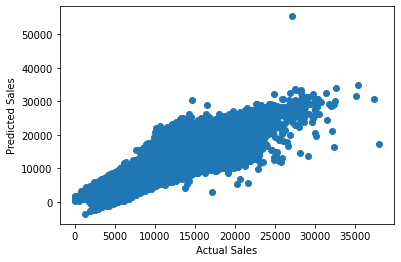

In [128]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

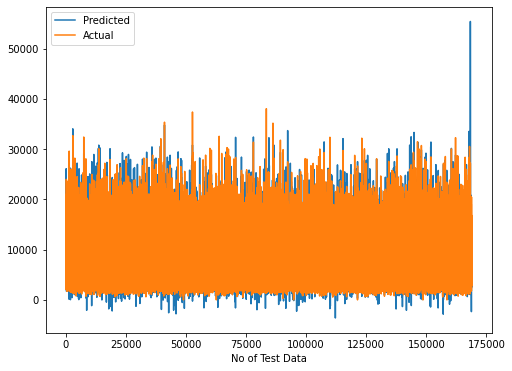

In [129]:
plt.figure(figsize=(8,6))
plt.plot(y_pred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.xlabel('No of Test Data')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Residual Analysis')

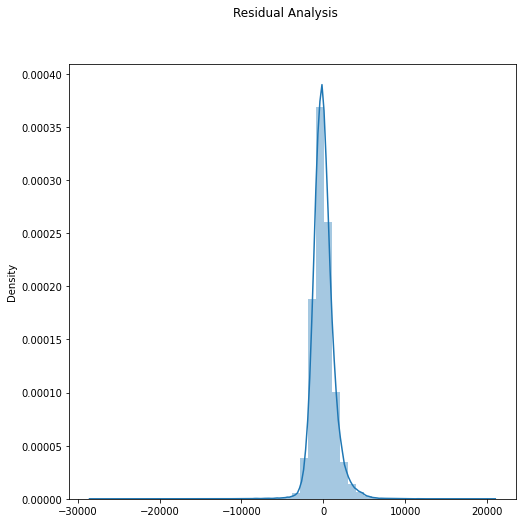

In [130]:
fig=plt.figure(figsize=(8,8))
  
sns.distplot(y_test- y_pred,bins=50)

fig.suptitle('Residual Analysis')   

## Lasso Regression

In [131]:
lasso = Lasso(alpha=0.005,max_iter=3000)

In [132]:
lasso.fit(X_train,y_train)

Lasso(alpha=0.005, max_iter=3000)

In [133]:
lasso.score(X_train,y_train)

0.8175603866461852

In [134]:
y_pred_lasso = lasso.predict(X_test)

In [135]:
# Evalute the model

MSE  = mean_squared_error(y_test, y_pred_lasso)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_lasso)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_lasso)
print("R2 :" ,r2)
Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_lasso))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Adjusted_R2)

MSE : 1759864.7703730953
MAE : 952.3702552712609
RMSE : 1326.5989485798243
R2 : 0.8159026534526338
Adjusted R2 :  0.815881938835205


In [136]:
LaR = {'Model':'Lasso Regression', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2': r2,'Adjusted R2': Adjusted_R2 }
metrics = metrics.append(LaR, ignore_index=True)
metrics


,Model,MSE,MAE,RMSE,R2,Adjusted R2
0,Linear Regression,1.759882e+06,952.370677,1326.605439,0.815901,0.815880
1,Lasso Regression,1.759865e+06,952.370255,1326.598949,0.815903,0.815882


In [137]:
### Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-10,1e-5,1e-3,1e-1,1,5,10,20,30,50,100]}  
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=4)
lasso_regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.453e+11, tolerance: 4.881e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.468e+11, tolerance: 4.903e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

GridSearchCV(cv=4, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.001, 0.1, 1, 5, 10,
                                   20, 30, 50, 100]},
             scoring='neg_mean_squared_error')

In [138]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.001}

Using  {'alpha': 0.001}  the negative mean squared error is:  -1761680.6856497126


In [139]:
lasso_regressor.score(X_train,y_train)

-1761507.7765302048

In [140]:
y_pred_lasso = lasso_regressor.predict(X_test)

In [141]:
MSE  = mean_squared_error(y_test, y_pred_lasso)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_lasso)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_lasso)
print("R2 :" ,r2)
Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_lasso))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Adjusted_R2)


MSE : 1759878.4688100459
MAE : 952.3705660050666
RMSE : 1326.60411156081
R2 : 0.8159012204755455
Adjusted R2 :  0.8158805056968783


In [142]:
LaR = {'Model':'Lasso Regression (with HPT and CV)', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2': r2,'Adjusted R2': Adjusted_R2 }
metrics = metrics.append(LaR, ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2,Adjusted R2
0,Linear Regression,1.759882e+06,952.370677,1326.605439,0.815901,0.815880
1,Lasso Regression,1.759865e+06,952.370255,1326.598949,0.815903,0.815882
2,Lasso Regression (with HPT and CV),1.759878e+06,952.370566,1326.604112,0.815901,0.815881


## Ridge Regression

In [143]:
ridge = Ridge(alpha=0.1)

In [144]:
ridge.fit(X_train,y_train)

Ridge(alpha=0.1)

In [145]:
ridge.score(X_train, y_train)

0.8175604395077379

In [146]:
y_pred_ridge = ridge.predict(X_test)

In [147]:
MSE  = mean_squared_error(y_test, y_pred_ridge)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_ridge)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_ridge)
print("R2 :" ,r2)
Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_ridge))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Adjusted_R2)

MSE : 1759878.0643092683
MAE : 952.3748671903994
RMSE : 1326.6039591035708
R2 : 0.8159012627898875
Adjusted R2 :  0.8158805480159815


In [148]:
RR = {'Model':'Ridge Regression', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2': r2,'Adjusted R2': Adjusted_R2 }
metrics = metrics.append(RR,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2,Adjusted R2
0,Linear Regression,1.759882e+06,952.370677,1326.605439,0.815901,0.815880
1,Lasso Regression,1.759865e+06,952.370255,1326.598949,0.815903,0.815882
2,Lasso Regression (with HPT and CV),1.759878e+06,952.370566,1326.604112,0.815901,0.815881
3,Ridge Regression,1.759878e+06,952.374867,1326.603959,0.815901,0.815881


Text(0, 0.5, 'Predicted Sales')

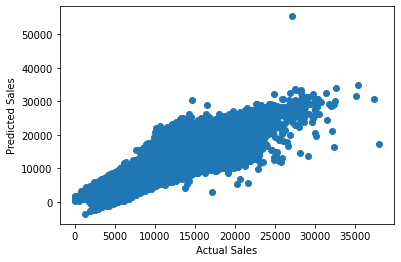

In [149]:
plt.scatter(y_test, y_pred_ridge)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

## XG Boost Regressor

In [150]:
xgbr = XGBRegressor()

In [151]:
xgbr.fit(X_train,y_train)

[09:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [152]:
xgbr.score(X_train, y_train)

0.879521608797531

In [153]:
y_pred_xgbr = xgbr.predict(X_test)

In [154]:
MSE  = mean_squared_error(y_test, y_pred_xgbr)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_xgbr)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgbr)
print("R2 :" ,r2)
Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_xgbr))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Adjusted_R2)

MSE : 1147086.3075406377
MAE : 781.5238530666539
RMSE : 1071.0211517708872
R2 : 0.8800046747715293
Adjusted R2 :  0.8799911729079666


In [155]:
XG = {'Model':'XGBoost Regression', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2': r2,'Adjusted R2': Adjusted_R2 }
metrics = metrics.append(XG,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2,Adjusted R2
0,Linear Regression,1.759882e+06,952.370677,1326.605439,0.815901,0.815880
1,Lasso Regression,1.759865e+06,952.370255,1326.598949,0.815903,0.815882
2,Lasso Regression (with HPT and CV),1.759878e+06,952.370566,1326.604112,0.815901,0.815881
3,Ridge Regression,1.759878e+06,952.374867,1326.603959,0.815901,0.815881
4,XGBoost Regression,1.147086e+06,781.523853,1071.021152,0.880005,0.879991


In [156]:
xgbr.feature_importances_

array([0.0357325 , 0.39955744, 0.13173221, 0.00209282, 0.06918853,
       0.03380062, 0.01720141, 0.02388906, 0.01245355, 0.01455694,
       0.        , 0.        , 0.        , 0.06598797, 0.02914953,
       0.13780993, 0.00901725, 0.01783023, 0.        ], dtype=float32)

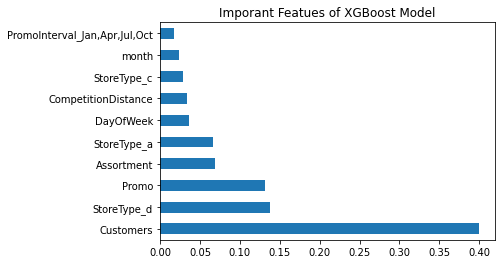

In [157]:
important_features = pd.Series(xgbr.feature_importances_, index=X.columns)
important_features.nlargest(10).plot(kind='barh')
plt.title('Imporant Featues of XGBoost Model')
plt.show()

In [158]:
#Cross Validation with Grid Search CV

xgbr = XGBRegressor()
parameters = {}
xgbr_regressor = GridSearchCV(xgbr,parameters, scoring='neg_mean_squared_error', cv=5)
xgbr_regressor.fit(X_train, y_train)


[09:26:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:27:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:27:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, estimator=XGBRegressor(), param_grid={},
             scoring='neg_mean_squared_error')

In [159]:
xgbr_regressor.best_score_

-1163138.387445404

In [160]:
xgbr_regressor.score(X_train, y_train)

-1163254.4040848252

In [161]:
# Cross Validation with cross_val_score and KFold
'''
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=4, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average scores :", kf_cv_scores)
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
'''

'\nfrom sklearn.model_selection import cross_val_score, KFold\nkfold = KFold(n_splits=4, shuffle=True)\nkf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )\nprint("K-fold CV average scores :", kf_cv_scores)\nprint("K-fold CV average score: %.2f" % kf_cv_scores.mean())\n'

In [162]:
y_pred_xgbr = xgbr_regressor.predict(X_test)

In [163]:
MSE  = mean_squared_error(y_test, y_pred_xgbr)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_xgbr)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgbr)
print("R2 :" ,r2)
Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_xgbr))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Adjusted_R2)

MSE : 1147086.3075406377
MAE : 781.5238530666539
RMSE : 1071.0211517708872
R2 : 0.8800046747715293
Adjusted R2 :  0.8799911729079666


In [164]:
XG = {'Model':'XGBoost Regression (with CV)', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2': r2,'Adjusted R2': Adjusted_R2 }
metrics = metrics.append(XG,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2,Adjusted R2
0,Linear Regression,1.759882e+06,952.370677,1326.605439,0.815901,0.815880
1,Lasso Regression,1.759865e+06,952.370255,1326.598949,0.815903,0.815882
2,Lasso Regression (with HPT and CV),1.759878e+06,952.370566,1326.604112,0.815901,0.815881
3,Ridge Regression,1.759878e+06,952.374867,1326.603959,0.815901,0.815881
4,XGBoost Regression,1.147086e+06,781.523853,1071.021152,0.880005,0.879991
5,XGBoost Regression (with CV),1.147086e+06,781.523853,1071.021152,0.880005,0.879991


## Stochastic Gradient Descent Regressor

In [165]:
SGD = SGDRegressor()

In [166]:
SGD.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor()

In [167]:
SGD.score(X_train,y_train)

0.8169418524807676

In [168]:
y_pred_SGD = SGD.predict(X_test)

In [169]:
#Evalute the model 
MSE  = mean_squared_error(y_test, y_pred_SGD)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_SGD)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_SGD)
print("R2 :" ,r2)
Adjusted_R2 =1-(1-r2_score(y_test, y_pred_SGD))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Adjusted_R2)

MSE : 1763188.2984175591
MAE : 956.9921499736778
RMSE : 1327.8510076125103
R2 : 0.8155549831631537
Adjusted R2 :  0.8155342294258942


In [170]:
GD = {'Model':'SGD Regression', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2': r2,'Adjusted R2': Adjusted_R2 }
metrics = metrics.append(GD,ignore_index=True)

## Random Forest Regressor

In [171]:
rf_regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)

In [172]:
rf_regressor.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(n_estimators=10, random_state=0)

In [173]:
rf_regressor.score(X_train,y_train)

0.9934455837196409

In [174]:
y_pred_rf = rf_regressor.predict(X_test)

In [175]:
#Evalute the model 
MSE  = mean_squared_error(y_test, y_pred_rf)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_rf)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_rf)
print("R2 :" ,r2)
Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_rf))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Adjusted_R2)

MSE : 329647.0112966973
MAE : 382.55220058937664
RMSE : 574.1489452195286
R2 : 0.9655160208337338
Adjusted R2 :  0.965512140699396


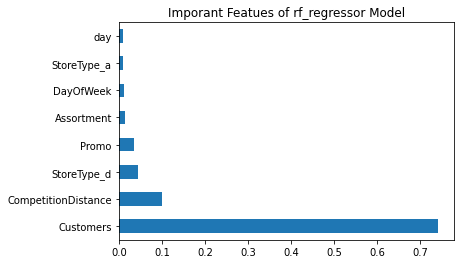

In [176]:
important_features = pd.Series(rf_regressor.feature_importances_, index=X.columns)
important_features.nlargest(8).plot(kind='barh')
plt.title('Imporant Featues of rf_regressor Model')
plt.show()

In [177]:
RF = {'Model':'Random Forest Regression ', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2': r2,'Adjusted R2': Adjusted_R2 }
metrics = metrics.append(RF,ignore_index=True)


In [178]:
#Cross Validation with Grid Search CV

rf_regressor = RandomForestRegressor()
parameters = {'n_estimators':[5,10,25],'random_state':[0]}
rf_regressor = GridSearchCV(rf_regressor,parameters, scoring='neg_mean_squared_error', cv=5)
rf_regressor.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [5, 10, 25], 'random_state': [0]},
             scoring='neg_mean_squared_error')

In [179]:
print("The best fit n_estimator is found out to be :" ,rf_regressor.best_params_)
print("\nUsing ",rf_regressor.best_params_, " the negative mean squared error is: ", rf_regressor.best_score_)

The best fit n_estimator is found out to be : {'n_estimators': 25, 'random_state': 0}

Using  {'n_estimators': 25, 'random_state': 0}  the negative mean squared error is:  -339083.6237532797


In [180]:
rf_regressor.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [5, 10, 25], 'random_state': [0]},
             scoring='neg_mean_squared_error')>

In [181]:
y_pred_rf = rf_regressor.predict(X_test)

In [182]:
#Evalute the model 

MSE  = mean_squared_error(y_test, y_pred_rf)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_rf)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_rf)
print("R2 :" ,r2)
Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_rf))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Adjusted_R2)


MSE : 304084.59798415506
MAE : 366.5005616486755
RMSE : 551.4386620324649
R2 : 0.9681900742845501
Adjusted R2 :  0.968186495034474


In [183]:
RF = {'Model':'Random Forest Regression (with HPT and CV)', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2': r2,'Adjusted R2': Adjusted_R2 }
metrics = metrics.append(RF,ignore_index=True)


# Final Results

In [184]:
print('Base Model')
print('The mean sales value is ',round(df.Sales.mean(),2))
print('The standard deviation sales value is', round(df.Sales.std(),2))

Base Model
The mean sales value is  6955.51
The standard deviation sales value is 3104.21


In [187]:
pd.set_option('display.float_format', lambda x: '%0.3f' % x)
metrics

,Model,MSE,MAE,RMSE,R2,Adjusted R2
0,Linear Regression,1759881.992,952.371,1326.605,0.816,0.816
1,Lasso Regression,1759864.770,952.370,1326.599,0.816,0.816
2,Lasso Regression (with HPT and CV),1759878.469,952.371,1326.604,0.816,0.816
3,Ridge Regression,1759878.064,952.375,1326.604,0.816,0.816
4,XGBoost Regression,1147086.308,781.524,1071.021,0.880,0.880
5,XGBoost Regression (with CV),1147086.308,781.524,1071.021,0.880,0.880
6,SGD Regression,1763188.298,956.992,1327.851,0.816,0.816
7,Random Forest Regression,329647.011,382.552,574.149,0.966,0.966
8,Random Forest Regression (with HPT and CV),304084.598,366.501,551.439,0.968,0.968
